# Emerging Topics final code

This code was created from Martha and Sean's emerging topic code.

In [51]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

### Data Ingestion

In [2]:
# full corpus
#df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
#df = pd.read_pickle("../../data/final/dashboard_data/pandemic_corpus.pkl")
#df.reset_index(inplace=True)

# coronavirus corpus
df = pd.read_pickle("../../data/final/dashboard_data/corona_corpus.pkl")
df.reset_index(inplace=True)

In [3]:
df.head()

,level_0,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,...,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed
0,413,413,287859,701145,As scientists with a keen interest in non-Hodg...,2009,Adult; Alleles; Biological Assay; blastocyst; ...,BIOMEDICAL (BASIC),HHS,NIH,...,As scientists with a keen interest in non-Hodg...,A,2071,I,"[scientist, keen, interest, non-hodgkin, lymph...","[scientist, keen, interest, non-hodgkin, lymph...","[scientist, keen, interest, non-hodgkin, lymph...","[scientist, keen_interest, non-hodgkin_lymphom...","[scientist, keen_interest, non_hodgkin_lymphom...","[scientist, keen_interest, non_hodgkin_lymphom..."
1,1038,1038,370882,586081,Objective(s): Develop environmentally acceptab...,2010,Area; Asians; Behavior; Biocontrols; Biology; ...,"DETECTION CONTROL, AND AREA-WIDE MANAGEMENT OF...",USDA,ARS,...,Develop environmentally acceptable and economi...,D,1068,0,"[develop, environmentally, acceptable, economi...","[develop, environmentally, acceptable, economi...","[develop, environmentally, acceptable, economi...","[develop, environmentally, acceptable, economi...","[develop, environmentally, acceptable, economi...","[environmentally, acceptable, economically_fea..."
2,2555,2555,21329,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,...,Human coronaviruses (HCoV) were initially iden...,H,2066,y,"[human, coronaviruse, HCoV, initially, identif...","[human, coronaviruse, hcov, initially, identif...","[human, coronaviruse, hcov, initially, identif...","[human, coronaviruse_hcov, initially, identify...","[human, coronaviruse_hcov, initially, identify...","[human, coronaviruse_hcov, initially, acute, r..."
3,2928,2928,23454,154633,DESCRIPTION (provided by applicant): The pro-a...,2008,1-Phosphatidylinositol 3-Kinase; Address; Alph...,NOVEL MECHANISMS OF PTEN GENE REGULATION,HHS,NIH,...,The pro-apoptotic tumor suppressor gene PTEN (...,T,2141,N,"[pro-apoptotic, tumor, suppressor, gene, pten,...","[pro-apoptotic, tumor, suppressor, gene, pten,...","[pro-apoptotic, tumor, suppressor, gene, pten,...","[pro-apoptotic, tumor, suppressor, gene, pten,...","[pro_apoptotic, tumor, suppressor, gene, pten,...","[pro_apoptotic, tumor, suppressor, gene, pten,..."
4,3217,3217,21995,154182,DESCRIPTION (provided by applicant): Category ...,2008,Agar; assay development; base; Biochemical; Bi...,YEAST-BASED HIGH-THROUGHPUT ASSAYS FOR PROTEAS...,HHS,NIH,...,"Category A, B & C priority pathogens include b...",C,2147,n,"[category, a, b, c, priority, pathogen, includ...","[category, a, b, c, priority, pathogen, includ...","[category, b, c, priority, pathogen, biologica...","[category, b, c, priority, pathogen, biologica...","[category, priority, pathogen, biological, age...","[category, priority, pathogen, biological, age..."


In [4]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_frqwds_removed"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [5]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [6]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(model, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [7]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [8]:
# create model

num_topics = 30 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

  Model time: 2.3819169998168945


In [9]:
print_topics(nmf_model, tfidf_vectorizer, 10)


Topic 0:
('rna', 2.701964047223399)
('replication', 1.883876718202813)
('viral', 1.6131435990689507)
('protein', 1.4368932283112765)
('coronavirus', 1.3268361368060138)
('virus', 1.0330762699564857)
('coronaviruse', 0.9298537245944838)
('genome', 0.7878428708335217)
('host', 0.7348722372658543)
('interaction', 0.6665080528080868)

Topic 1:
('hsv', 1.9528548414943678)
('woman', 0.2826939475627357)
('shedding', 0.2366684457810575)
('genital', 0.22517262408776487)
('reactivation', 0.21140446249874703)
('cds', 0.19136501375884632)
('infection', 0.1824495895759714)
('cell', 0.14407838765079758)
('subject', 0.1370929990203455)
('genital_hsv', 0.13302060105085614)

Topic 2:
('ebv', 1.919880068784432)
('cell', 0.47159359887164026)
('patient', 0.25334740764407954)
('nhl', 0.23240012445805835)
('lymphoma', 0.2137457016379734)
('latent', 0.18319396354312)
('latency', 0.17421277887102418)
('malignancy', 0.16917767440372383)
('ctl', 0.1599594978230779)
('line', 0.1452690695856613)

Topic 3:
('siv'

### Emerging Topics

In [10]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [11]:
df["START_YEAR"].value_counts()

2008    107
2009     91
2016     89
2010     89
2015     80
2011     74
2012     71
2013     69
2014     62
2017     51
2018     45
2007     31
2019     30
2005     26
2004     18
2006     17
2001     10
1997      7
1985      5
1991      5
2002      5
2003      4
1998      4
1981      3
1987      3
1975      2
2000      2
1980      2
1988      2
1990      2
1999      2
1992      1
1996      1
1979      1
1977      1
Name: START_YEAR, dtype: int64

In [12]:
df.dtypes

level_0                         int64
index                           int64
original index                  int64
PROJECT_ID                     object
ABSTRACT                       object
FY                             object
PROJECT_TERMS                  object
PROJECT_TITLE                  object
DEPARTMENT                     object
AGENCY                         object
IC_CENTER                      object
PROJECT_NUMBER                 object
PROJECT_START_DATE             object
PROJECT_END_DATE               object
CONTACT_PI_PROJECT_LEADER      object
OTHER_PIS                      object
CONGRESSIONAL_DISTRICT         object
DUNS_NUMBER                    object
ORGANIZATION_NAME              object
ORGANIZATION_CITY              object
ORGANIZATION_STATE             object
ORGANIZATION_ZIP               object
ORGANIZATION_COUNTRY           object
BUDGET_START_DATE              object
BUDGET_END_DATE                object
CFDA_CODE                      object
FY.y        

In [13]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


In [14]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [15]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
0,1975,0.014719,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.010401,...,0.000147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000952,0.000000,0.009121
1,1977,0.087654,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.008056,0.000000,...,0.000000,0.000000,0.000000,0.001722,0.000000,0.018315,0.000000,0.002187,0.003123,0.007287
2,1979,0.096337,0.000990,0.001070,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.015311,0.000000,0.000000,0.000000,0.000000
3,1980,0.002056,0.005271,0.010611,0.023013,0.0,0.000000,0.024648,0.000000,0.001579,...,0.000000,0.000554,0.031917,0.012979,0.000000,0.000000,0.004405,0.000129,0.005196,0.000000
4,1981,0.000000,0.000286,0.202569,0.014234,0.0,0.000207,0.000000,0.001520,0.002494,...,0.000000,0.000000,0.027940,0.001416,0.000404,0.003442,0.003563,0.009755,0.001085,0.010076


In [16]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [17]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
25,2010,0.006116,0.018392,0.012106,0.047366,0.005284,0.007487,0.007749,0.004341,0.009171,...,0.004622,0.005398,0.010263,0.005081,0.012818,0.004079,0.006609,0.017430,0.012330,0.004059
26,2011,0.002694,0.040120,0.010999,0.033772,0.003983,0.010300,0.008341,0.015465,0.011785,...,0.002811,0.005979,0.011495,0.003228,0.010195,0.006527,0.002411,0.015688,0.013773,0.008213
27,2012,0.002576,0.029528,0.016792,0.012557,0.030212,0.011367,0.011382,0.006568,0.010180,...,0.005712,0.008804,0.014743,0.002485,0.010456,0.008302,0.010615,0.013257,0.014138,0.006284
28,2013,0.008925,0.016780,0.014043,0.015694,0.026977,0.008513,0.011282,0.007909,0.008420,...,0.016941,0.005754,0.019425,0.001423,0.013183,0.003585,0.012496,0.004071,0.005286,0.006029
29,2014,0.004612,0.023023,0.011006,0.002615,0.028350,0.008458,0.008750,0.009770,0.010301,...,0.009547,0.014525,0.002635,0.005795,0.006228,0.016256,0.015625,0.003437,0.001735,0.007844
30,2015,0.005377,0.021673,0.013378,0.005960,0.027162,0.009563,0.007730,0.008545,0.009152,...,0.008517,0.017940,0.004723,0.014086,0.003859,0.013535,0.011185,0.005452,0.001641,0.013311
31,2016,0.003936,0.017136,0.014823,0.012599,0.026931,0.005906,0.005463,0.003317,0.008672,...,0.006798,0.011102,0.005119,0.008462,0.004201,0.022358,0.012693,0.008199,0.002097,0.013974
32,2017,0.008222,0.031416,0.010459,0.008892,0.003271,0.009116,0.003731,0.003123,0.011993,...,0.002781,0.020116,0.004126,0.013442,0.005256,0.016472,0.005205,0.001923,0.002143,0.023286
33,2018,0.003299,0.021802,0.022016,0.014036,0.004250,0.012002,0.009216,0.004512,0.013910,...,0.001621,0.017332,0.006594,0.009488,0.008153,0.004009,0.006385,0.005569,0.002635,0.021391
34,2019,0.000447,0.000581,0.031756,0.019061,0.002193,0.015345,0.008953,0.004201,0.022291,...,0.001187,0.031578,0.002253,0.039889,0.001933,0.007031,0.012003,0.012933,0.000939,0.038945


In [18]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [19]:
topic_slopes

[-0.00019848811936150197,
 -0.0016931371531841506,
 0.0013758021318922133,
 -0.002528251242235157,
 -0.000981719669383273,
 0.00039196635822023797,
 -0.00024102014716605158,
 -0.0006675519562463285,
 0.0008583180724004593,
 -0.0005561634988064929,
 -4.826059775366361e-05,
 0.0010573260943963461,
 -0.0005846268040185649,
 0.0007436683559283631,
 -0.0009682267940902773,
 0.00030630477496243654,
 -0.0010679827912339248,
 -0.0007386640883656024,
 0.004751475504194529,
 -0.0010390312866082683,
 -0.0005173222048306149,
 0.002370364741003974,
 -0.0012140823928739359,
 0.0026744592032130784,
 -0.001015608366113269,
 0.0006265871504283887,
 0.0002755152290854694,
 -0.0009307389921202594,
 -0.0015158703180361895,
 0.003154750133518492]

In [20]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [21]:
hot_cold

['cold',
 'cold',
 'hot',
 'cold',
 'cold',
 'hot',
 'cold',
 'cold',
 'hot',
 'cold',
 'cold',
 'hot',
 'cold',
 'hot',
 'cold',
 'hot',
 'cold',
 'cold',
 'hot',
 'cold',
 'cold',
 'hot',
 'cold',
 'hot',
 'cold',
 'hot',
 'hot',
 'cold',
 'cold',
 'hot']

In [22]:
topic_words = str_topics(nmf_model, tfidf_vectorizer, top_n=10)

In [23]:
topic_words

['rna, replication, viral, protein, coronavirus, virus, coronaviruse, genome, host, interaction',
 'hsv, woman, shedding, genital, reactivation, cds, infection, cell, subject, genital_hsv',
 'ebv, cell, patient, nhl, lymphoma, latent, latency, malignancy, ctl, line',
 'siv, cd4, infect, aids, macaque, cell, progression, monocyte, rhesus_macaque, infection',
 'immune, polygenic, trait, protective, immunity, kinetic, phenotype, host, conserve, cc',
 'npc, family, multiplex, individual, gene, ebv, ethnic, exogenous, occupational, antibody',
 'vaccine, sars_cov, sar_cov, virus, attenuate, protein, sar, candidate, sars, live',
 'mouse, aged, cell, severe, anti_virus, balb_c, young, rdc, respiratory, infect',
 'lymphoma, inflammation, aids, cancer, blood, ebv, descriptive, noncardia_gastric, iib, helicobacter_pylori',
 'cr, nrf2, lifespan, protection, longevity, skn, transcription, carcinogenesis, diet, c_elegans',
 'gene, uncharacterize, rp, virus, lav_ebov, candidate, encode, entry, produc

In [24]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 


In [25]:
reg_topics

,Slope,Hot or Cold,Topic Words
0,-0.000198,cold,"rna, replication, viral, protein, coronavirus,..."
1,-0.001693,cold,"hsv, woman, shedding, genital, reactivation, c..."
2,0.001376,hot,"ebv, cell, patient, nhl, lymphoma, latent, lat..."
3,-0.002528,cold,"siv, cd4, infect, aids, macaque, cell, progres..."
4,-0.000982,cold,"immune, polygenic, trait, protective, immunity..."
5,0.000392,hot,"npc, family, multiplex, individual, gene, ebv,..."
6,-0.000241,cold,"vaccine, sars_cov, sar_cov, virus, attenuate, ..."
7,-0.000668,cold,"mouse, aged, cell, severe, anti_virus, balb_c,..."
8,0.000858,hot,"lymphoma, inflammation, aids, cancer, blood, e..."
9,-0.000556,cold,"cr, nrf2, lifespan, protection, longevity, skn..."


In [27]:
#reg_topics.to_csv("./reg_topics.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)

## Create plots - top 5 hot and cold topics, static plots

In [26]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
25,2010,0.006116,0.018392,0.012106,0.047366,0.005284,0.007487,0.007749,0.004341,0.009171,...,0.004622,0.005398,0.010263,0.005081,0.012818,0.004079,0.006609,0.017430,0.012330,0.004059
26,2011,0.002694,0.040120,0.010999,0.033772,0.003983,0.010300,0.008341,0.015465,0.011785,...,0.002811,0.005979,0.011495,0.003228,0.010195,0.006527,0.002411,0.015688,0.013773,0.008213
27,2012,0.002576,0.029528,0.016792,0.012557,0.030212,0.011367,0.011382,0.006568,0.010180,...,0.005712,0.008804,0.014743,0.002485,0.010456,0.008302,0.010615,0.013257,0.014138,0.006284
28,2013,0.008925,0.016780,0.014043,0.015694,0.026977,0.008513,0.011282,0.007909,0.008420,...,0.016941,0.005754,0.019425,0.001423,0.013183,0.003585,0.012496,0.004071,0.005286,0.006029
29,2014,0.004612,0.023023,0.011006,0.002615,0.028350,0.008458,0.008750,0.009770,0.010301,...,0.009547,0.014525,0.002635,0.005795,0.006228,0.016256,0.015625,0.003437,0.001735,0.007844
30,2015,0.005377,0.021673,0.013378,0.005960,0.027162,0.009563,0.007730,0.008545,0.009152,...,0.008517,0.017940,0.004723,0.014086,0.003859,0.013535,0.011185,0.005452,0.001641,0.013311
31,2016,0.003936,0.017136,0.014823,0.012599,0.026931,0.005906,0.005463,0.003317,0.008672,...,0.006798,0.011102,0.005119,0.008462,0.004201,0.022358,0.012693,0.008199,0.002097,0.013974
32,2017,0.008222,0.031416,0.010459,0.008892,0.003271,0.009116,0.003731,0.003123,0.011993,...,0.002781,0.020116,0.004126,0.013442,0.005256,0.016472,0.005205,0.001923,0.002143,0.023286
33,2018,0.003299,0.021802,0.022016,0.014036,0.004250,0.012002,0.009216,0.004512,0.013910,...,0.001621,0.017332,0.006594,0.009488,0.008153,0.004009,0.006385,0.005569,0.002635,0.021391
34,2019,0.000447,0.000581,0.031756,0.019061,0.002193,0.015345,0.008953,0.004201,0.022291,...,0.001187,0.031578,0.002253,0.039889,0.001933,0.007031,0.012003,0.012933,0.000939,0.038945


In [27]:
# Sean's plots - legend

leg = str_topics(nmf_model, tfidf_vectorizer, top_n=5)

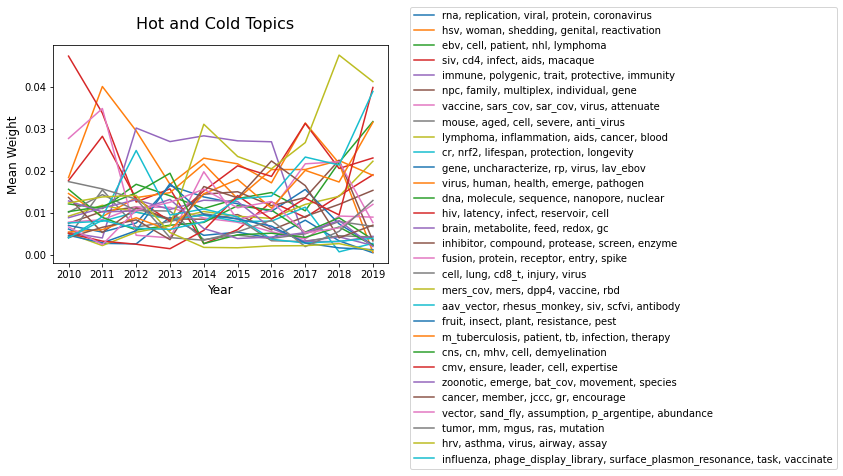

In [28]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [29]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [30]:
# {column index, slope} - ex) 1: Topic 0 because Topic 0 is column 1 in the dataframe

topic_results

{1: -0.00019848811936150197,
 2: -0.0016931371531841506,
 3: 0.0013758021318922133,
 4: -0.002528251242235157,
 5: -0.000981719669383273,
 6: 0.00039196635822023797,
 7: -0.00024102014716605158,
 8: -0.0006675519562463285,
 9: 0.0008583180724004593,
 10: -0.0005561634988064929,
 11: -4.826059775366361e-05,
 12: 0.0010573260943963461,
 13: -0.0005846268040185649,
 14: 0.0007436683559283631,
 15: -0.0009682267940902773,
 16: 0.00030630477496243654,
 17: -0.0010679827912339248,
 18: -0.0007386640883656024,
 19: 0.004751475504194529,
 20: -0.0010390312866082683,
 21: -0.0005173222048306149,
 22: 0.002370364741003974,
 23: -0.0012140823928739359,
 24: 0.0026744592032130784,
 25: -0.001015608366113269,
 26: 0.0006265871504283887,
 27: 0.0002755152290854694,
 28: -0.0009307389921202594,
 29: -0.0015158703180361895,
 30: 0.003154750133518492}

In [31]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [32]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

In [33]:
sort_slopes

[(19, 0.004751475504194529),
 (30, 0.003154750133518492),
 (24, 0.0026744592032130784),
 (22, 0.002370364741003974),
 (3, 0.0013758021318922133),
 (12, 0.0010573260943963461),
 (9, 0.0008583180724004593),
 (14, 0.0007436683559283631),
 (26, 0.0006265871504283887),
 (6, 0.00039196635822023797),
 (16, 0.00030630477496243654),
 (27, 0.0002755152290854694),
 (11, -4.826059775366361e-05),
 (1, -0.00019848811936150197),
 (7, -0.00024102014716605158),
 (21, -0.0005173222048306149),
 (10, -0.0005561634988064929),
 (13, -0.0005846268040185649),
 (8, -0.0006675519562463285),
 (18, -0.0007386640883656024),
 (28, -0.0009307389921202594),
 (15, -0.0009682267940902773),
 (5, -0.000981719669383273),
 (25, -0.001015608366113269),
 (20, -0.0010390312866082683),
 (17, -0.0010679827912339248),
 (23, -0.0012140823928739359),
 (29, -0.0015158703180361895),
 (2, -0.0016931371531841506),
 (4, -0.002528251242235157)]

In [34]:
top_slopes

[19, 30, 24, 22, 3]

In [35]:
bottom_slopes

[17, 23, 29, 2, 4]

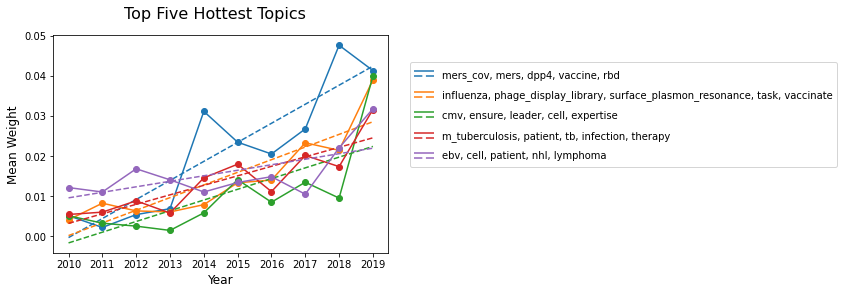

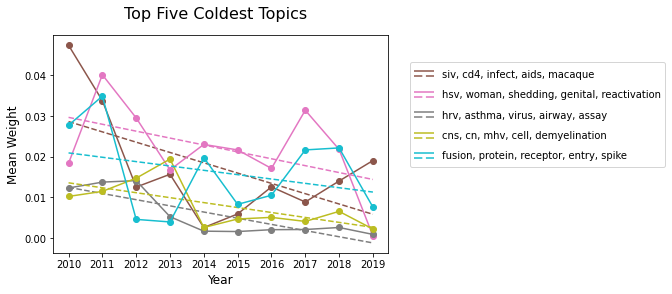

In [61]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure()
fig.suptitle('Top Five Hottest Topics', fontsize=16)
ax = fig.add_subplot(111)
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o')
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()


#Make Graphs
#leg = []

bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top Five Coldest Topics', fontsize=16)
ax = fig.add_subplot(111)
i = 0
for n in bottom_slopes:
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color_list[i+5])
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()


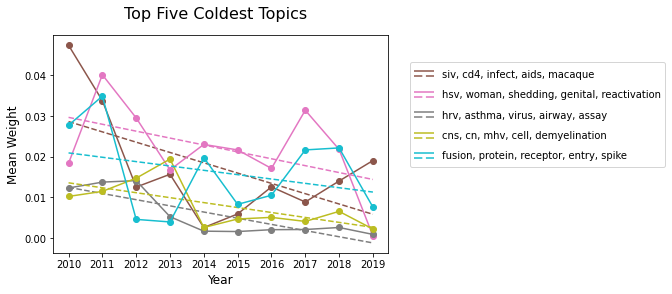

In [44]:
#Make Graphs
#leg = []

bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top Five Coldest Topics', fontsize=16)
ax = fig.add_subplot(111)
i = 0
for n in bottom_slopes:
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color_list[i+5])
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [38]:
bottom_slopes

[4, 2, 29, 23, 17]

In [39]:
[leg[x-1] for x in bottom_slopes]

['siv, cd4, infect, aids, macaque',
 'hsv, woman, shedding, genital, reactivation',
 'hrv, asthma, virus, airway, assay',
 'cns, cn, mhv, cell, demyelination',
 'fusion, protein, receptor, entry, spike']

In [55]:
color_list

In [ ]:
#Melt to get the data for graphing purposes 
topic_df = topic_frame.melt(id_vars =['START_YEAR'], var_name = "Topic", value_name = "Weight")